<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Zero-shot-learning" data-toc-modified-id="Zero-shot-learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Zero-shot learning</a></span></li><li><span><a href="#Construct-linear-regressor" data-toc-modified-id="Construct-linear-regressor-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construct linear regressor</a></span><ul class="toc-item"><li><span><a href="#Procrustes" data-toc-modified-id="Procrustes-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Procrustes</a></span></li><li><span><a href="#Rigid" data-toc-modified-id="Rigid-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Rigid</a></span></li><li><span><a href="#Least-squares" data-toc-modified-id="Least-squares-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Least squares</a></span></li><li><span><a href="#Zero-shot-learning" data-toc-modified-id="Zero-shot-learning-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Zero-shot learning</a></span></li></ul></li><li><span><a href="#21k" data-toc-modified-id="21k-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>21k</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Compute-error" data-toc-modified-id="Compute-error-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Compute error</a></span></li></ul></li></ul></div>

# Zero-shot learning
Let's compare different language models

In [1]:
import numpy as np
from matplotlib import pyplot as plt
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Construct linear regressor

In [3]:
import torch
from torchnlp.word_to_vector import FastText, GloVe, CharNGram

# wordvecs = GloVe(cache='/mnt/fs2/bsorsch/manifold/GloVe', dim=300)
wordvecs = FastText(cache='/mnt/fs2/bsorsch/manifold/FastText/')

In [4]:
import os
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
model = 'resnet50'
save_dir = os.path.join(root, model+'/')
centers = np.load(save_dir + 'centers.npy')
manifolds = np.load(save_dir + 'manifolds.npy',allow_pickle=True)
root_paths = np.load(root + 'root_paths_1k.npy',allow_pickle=True)

ilsvrc_root = '/mnt/fs2/bsorsch/manifold/embeddings/ILSVRC/'
model = 'resnet50'
save_dir = os.path.join(ilsvrc_root, model+'/')
centers_1k = np.load(save_dir + 'centers.npy')
manifolds_1k = np.load(save_dir + 'manifolds.npy')
root_paths_1k = np.load('../manifold_old/data/ILSVRC_root_paths.npy',allow_pickle=True)

In [5]:
# Include only first name
wvs = []
embedding_idx = []
for i,rp in enumerate(root_paths[:1000]):
    wv = []
    name = rp[0]
    parts = name.split(', ')
    for part in parts:
        subparts = part.split(' ')
        for subpart in subparts:
            subsubparts = subpart.split('-')
            for subsubpart in subsubparts:
                wvtmp = wordvecs[subsubpart.lower()].numpy()
                if np.any(wvtmp!=0):
                    wv.append(wvtmp)  
    if wv:
        embedding_idx.append(i)
    else:
        wv = [np.nan*np.ones(300)]
    wvs.append(np.stack(wv).mean(0))
wvs = np.stack(wvs)
embedding_idx = np.stack(embedding_idx)
# wvs = wvs[embedding_idx]

In [6]:
# Include only first name
wvs_1k = []
embedding_idx_1k = []
for i,rp in enumerate(root_paths_1k):
    wv = []
    name = rp[0]
    parts = name.split(', ')
    for part in parts:
        subparts = part.split(' ')
        for subpart in subparts:
            subsubparts = subpart.split('-')
            for subsubpart in subsubparts:
                wvtmp = wordvecs[subsubpart.lower()].numpy()
                if np.any(wvtmp!=0):
                    wv.append(wvtmp)    
    if wv:
        embedding_idx_1k.append(i)
    else:
        wv = [np.nan*np.ones(300)]
    wvs_1k.append(np.stack(wv).mean(0))
wvs_1k = np.stack(wvs_1k)
embedding_idx_1k = np.stack(embedding_idx_1k)
# wvs_1k = wvs_1k[embedding_idx_1k]                   # keep only wvs with an embedding

In [7]:
# Normalize
WVMEAN = wvs_1k.mean(0)

wvs -= WVMEAN
wvs_1k -= WVMEAN
wvs /= np.linalg.norm(wvs, axis=-1,keepdims=True)
wvs_1k /= np.linalg.norm(wvs_1k, axis=-1,keepdims=True)
wvs = np.nan_to_num(wvs)
wvs_1k = np.nan_to_num(wvs_1k)

In [8]:
# # Normalize
# manifolds_norm = manifolds / np.linalg.norm(manifolds, axis=-1,keepdims=True)
# manifolds_1k_norm = manifolds_1k / np.linalg.norm(manifolds_1k, axis=-1,keepdims=True)
# centers_norm = manifolds_norm.mean(1)
# centers_1k_norm = manifolds_1k_norm.mean(1)

## Procrustes

In [9]:
Xtrain = wvs_1k
Ytrain = centers_1k
Xtest = wvs
Ytest = centers

In [10]:
def procrustes(X,Y):
    bx = X.mean(0)
    by = Y.mean(0)

    ax = 1/np.sqrt(np.sum((X - bx)**2))
    ay = 1/np.sqrt(np.sum((Y - by)**2))

    Xprime = ax*(X - bx)
    Yprime = ay*(Y - by)

    U,S,Vh = np.linalg.svd(Xprime.T@Yprime,full_matrices=False)

    O = U@Vh
    Yhat = Xprime@O / ay + by

    overlap = (Yhat*Y).sum() / np.sqrt(np.sum(Yhat**2))/ np.sqrt(np.sum(Y**2))

    return ax,ay,bx,by,O,overlap


def map_procrustes(X,ax,ay,bx,by,O):
    return ax/ay*(X-bx)@O + by

In [11]:
ax,ay,bx,by,O,overlap = procrustes(Xtrain,Ytrain)

In [12]:
Yhat = map_procrustes(Xtest,ax,ay,bx,by,O)

## Rigid

In [13]:
def rigid(Xtrain,Xtest,Ytrain,Ytest):
    X = Xtrain - Xtrain.mean(0)
    Y = Ytrain - Ytrain.mean(0)
    S = X.T@Y

    U,Sig,V = np.linalg.svd(S)
    V = V.T

    R = V[:,:300]@U.T
    t = Ytrain.mean(0) - R@Xtrain.mean(0)

    Xtest_embed = Xtest@R.T 
    Xtrain_embed = Xtrain@R.T 

    resid1k = np.linalg.norm(Xtrain_embed - Ytrain,axis=-1)
    resid = np.linalg.norm(Xtest_embed - Ytest,axis=-1)
    cos_ang = (Xtest_embed*Ytest).sum(-1)
    cos_ang /= np.linalg.norm(Ytest,axis=-1) * np.linalg.norm(Xtest_embed, axis=-1)
    cos_ang_1k = (Xtrain_embed*Ytrain).sum(-1)
    cos_ang_1k /= np.linalg.norm(Ytrain,axis=-1) * np.linalg.norm(Xtrain_embed, axis=-1)

    return R,t,resid,resid1k,cos_ang,cos_ang_1k
    

/home/bsorsch/.torch3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/bsorsch/.torch3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/bsorsch/.torch3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


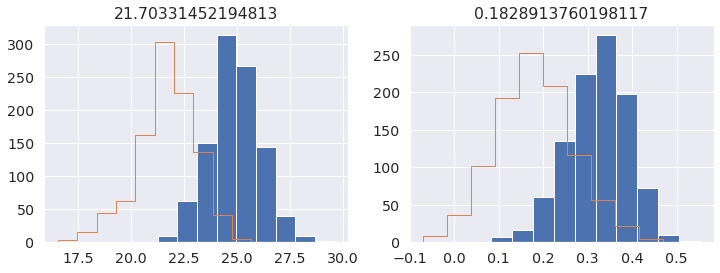

In [14]:
R,t,resid,resid_1k,cos_ang,cos_ang_1k = rigid(wvs_1k,wvs,centers_1k,centers)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

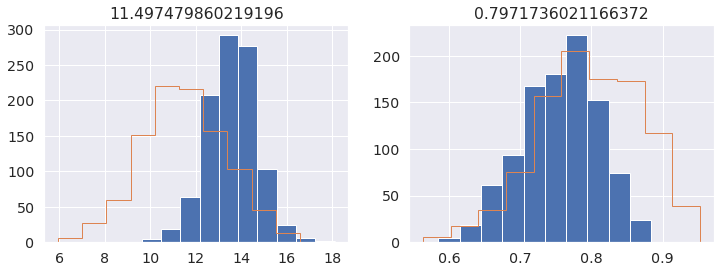

In [15]:
R,t,resid,resid_1k,cos_ang,cos_ang_1k = rigid(wvs_1k,wvs,centers_1k,centers)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

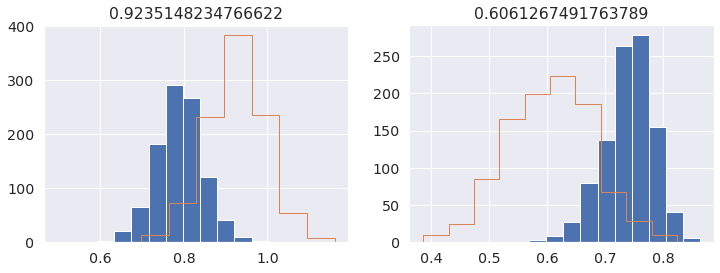

In [16]:
Rnorm,tnorm,resid,resid_1k,cos_ang,cos_ang_1k = rigid(wvs_1k,wvs,centers_1k_norm,centers_norm)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

$$ \|Ax-b\|^2 $$

$$ x = (A^TA)^{-1} A^T b $$

## Least squares

In [17]:
def least_squares(Xtrain,Xtest,Ytrain,Ytest):
    n_classes = len(Xtrain)
    M = wvs.shape[-1]

    A = np.concatenate([Xtrain,np.ones((n_classes,1))],axis=1)
    x = np.linalg.pinv(A.T@A+1e1)@A.T@Ytrain
    W = x[:M]
    b = x[-1]

    # Residuals
    resid_1k = np.linalg.norm(Xtrain@W + b - Ytrain, axis=-1)
    cos_ang_1k = ((Xtrain@W + b)*Ytrain).sum(-1)
    cos_ang_1k /= np.linalg.norm(Xtrain@W + b,axis=-1) * np.linalg.norm(Ytrain, axis=-1)
    
    resid = np.linalg.norm(Xtest@W + b - Ytest, axis=-1)
    cos_ang = ((Xtest@W + b)*Ytest).sum(-1)
    cos_ang /= np.linalg.norm(Xtest@W + b,axis=-1) * np.linalg.norm(Ytest, axis=-1)
    
    return W, b, resid, resid_1k, cos_ang, cos_ang_1k

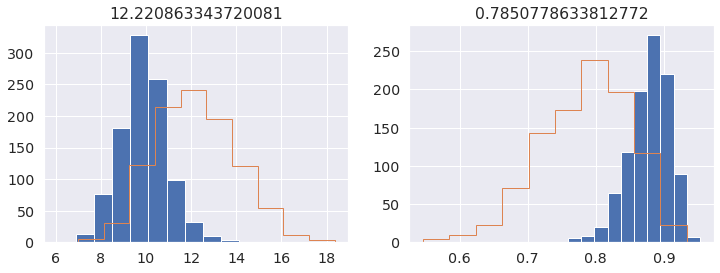

In [18]:
W, b, resid, resid_1k, cos_ang, cos_ang_1k = least_squares(wvs_1k,wvs,centers_1k,centers)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

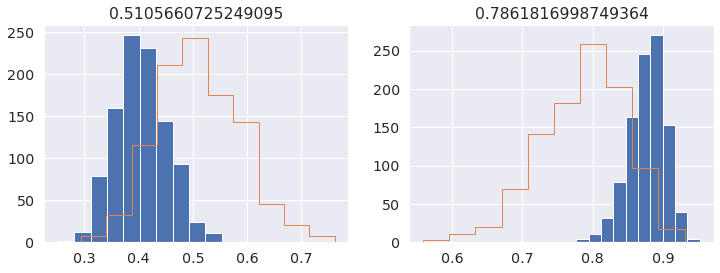

In [19]:
Wnorm, bnorm, resid, resid_1k, cos_ang, cos_ang_1k = least_squares(wvs_1k,wvs,centers_1k_norm,centers_norm)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

## Zero-shot learning

In [27]:
# @jit
def zero_shot(y1,y2,manifold):
    w = (y1 - y2)
    mu = (y1 + y2) / 2
    h = w@manifold.T - w@mu
    err = (h < 0).mean()
    return err

In [ ]:
zse = []
zse_ls = []
n_classes = 20
for i in tqdm(range(n_classes)):
    manifold = manifolds[i]
    y1 = wvs[i]@R.T + t
    y1_ls = wvs[i]@W + b
    for j in range(n_classes):
        if i!=j:
            y2 = wvs[j]@R.T + t
            y2_ls = wvs[j]@W + b
            zse.append(zero_shot(y1,y2,manifold))
            zse_ls.append(zero_shot(y1_ls,y2_ls,manifold))

zse = np.stack(zse).reshape(n_classes,n_classes-1)
zse_ls = np.stack(zse_ls).reshape(n_classes,n_classes-1)

Accuracy: 90%


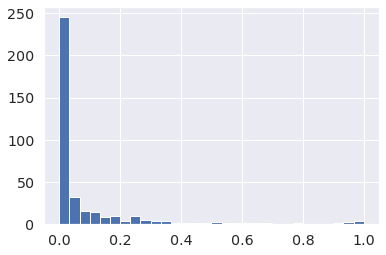

In [20]:
import numpy as npo
print('Accuracy: ' + str(int(100*(1-npo.nanmean(zse))))+'%')
plt.hist(zse.ravel(), bins=30);

Accuracy: 88%


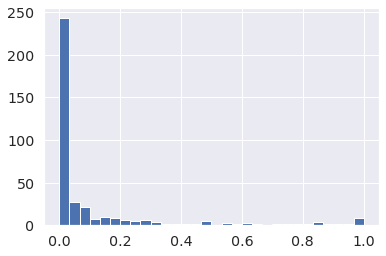

In [21]:
import numpy as npo
print('Accuracy: ' + str(int(100*(1-npo.nanmean(zse_ls))))+'%')
plt.hist(zse_ls.ravel(), bins=30);

# 21k

In [13]:
# Read synset files
import pandas as pd
wnids_21k = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt').to_numpy().squeeze()

In [14]:
# Wordnet tools
import pandas as pd
wordnet = np.load('../manifold_old/data/wordnet_hierarchy.npy', allow_pickle=True)
synset_wnids = pd.read_csv('../manifold_old/data/words.txt', sep='\t')
synset_wnids = synset_wnids.to_numpy()

def class_from_wnid(wnid):
    return  synset_wnids[np.where(synset_wnids==wnid)[0], 1][0]

In [15]:
# Read synset files
synset_list = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt')
synset_list = synset_list.to_numpy().squeeze()

# from utils import class_from_wnid
labels_21k = np.array([class_from_wnid(wnid) for wnid in synset_list])

In [16]:
# Keep only classes not in ILSVRC
ilsvrc_names = np.load('../manifold_old/data/ILSVRC_classes.npy')
# names = np.stack([name for name in names if not np.isin(name,ilsvrc_names)])

heldout_idxs = [i for i,name in enumerate(labels_21k) if not np.isin(name,ilsvrc_names)]

labels_20k = labels_21k[heldout_idxs]
wnids_20k = wnids_21k[heldout_idxs]

In [17]:
# Include only first name
wvs = []
embedding_idxs_all = []
for i,name in enumerate(labels_20k):
    wv = []
    parts = name.split(', ')
    for part in parts:
        subparts = part.split(' ')
        for subpart in subparts:
            subsubparts = subpart.split('-')
            for subsubpart in subsubparts:
                wvtmp = wordvecs[subsubpart.lower()].numpy()
                if np.any(wvtmp!=0):
                    wv.append(wvtmp)  
    if wv:
        embedding_idxs_all.append(i)
    else:
        wv = [np.nan*np.ones(300)]
    wvs.append(np.stack(wv).mean(0))
wvs = np.stack(wvs)
embedding_idxs_all = np.stack(embedding_idxs_all)

In [18]:
# # Keep only words with embeddings
# wvs = wvs[embedding_idxs_all]
# names = names[embedding_idxs_all]

In [19]:
# Normalize
wvs -= WVMEAN
wvs /= np.linalg.norm(wvs, axis=-1,keepdims=True)
wvs = np.nan_to_num(wvs)

In [21]:
# Procrustes
wve = map_procrustes(wvs,ax,ay,bx,by,O)

# Rigid
# wve_rigid = wvs@R.T + t

# wve_norm = wvs@Rnorm.T + tnorm
# # Least squares
# wve_ls = wvs@W + b
# wve_ls_norm = wvs@Wnorm + bnorm

In [22]:
# Make sure wvs with no embedding are set to nan
bad_idxs = np.setxor1d(np.arange(len(wve)),embedding_idxs_all)
for i in bad_idxs:
    wve[i] = np.nan*np.ones(2048)
#     wve_rigid[i] = np.nan*np.ones(2048)

## Data

In [23]:
# Find number of classes
path = '/mnt/fs2/bsorsch/manifold/held_out_imagenet/'
top_classes = np.load('/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/names.npy')

In [24]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [25]:
img_dir = '/mnt/fs0/datasets/ImageNet21k/'
from PIL import Image

def get_batch(i, wnid_dir, imgs, batch_size):
    xbatch = []
    for img in imgs[i*batch_size:(i+1)*batch_size]:
        try:
            x = Image.open(os.path.join(wnid_dir, img)).convert('RGB')
            xbatch.append(preprocess(x))
        except:
            pass
    if len(xbatch)==0:
        return None
    else:
        return torch.stack(xbatch)

In [26]:
from torchvision.utils import make_grid
def show_grid(im_tensor, nrow=8, title=None):
    im_grid = make_grid(im_tensor, nrow=nrow, padding=2)
    im_grid = im_grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im_grid = std * im_grid + mean
    im_grid = np.clip(im_grid, 0, 1)
    
    plt.figure(figsize=(15,2*len(input_tensor)//nrow))
    plt.imshow(im_grid)
    plt.axis('off')
    plt.title(title)

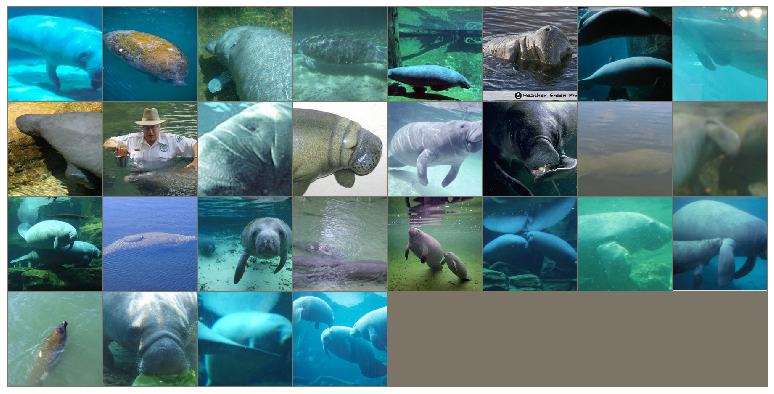

In [27]:
batch_size = 32
wnid = wnids_20k[12]
wnid_dir = os.path.join(img_dir, wnid)
imgs = os.listdir(wnid_dir)

input_tensor = get_batch(0, wnid_dir, imgs, batch_size)

show_grid(input_tensor)

## Model

In [28]:
import torch

In [29]:
model_name = 'resnet50'
# model_name = 'tf_efficientnet_l2_ns_475'
repo = 'pytorch/vision:v0.6.0'
# repo = 'rwightman/gen-efficientnet-pytorch'
model = torch.hub.load(repo, model_name, pretrained=True)

# model_dir = '/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/'+model_name+'_heldout/'

Using cache found in /home/bsorsch/.cache/torch/hub/pytorch_vision_v0.6.0


In [30]:
class WideResNetBackbone(torch.nn.Module):
    def __init__(self, model, module_idx):
        super(WideResNetBackbone, self).__init__()
        self.N = list(model.children())[-1].weight.shape[-1]
        self.features = torch.nn.Sequential(*list(model.children())[:-module_idx])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return x

In [31]:
backbone = WideResNetBackbone(model, 1)
backbone = backbone.cuda().eval();

In [32]:
# wve = wve[heldout_idxs]
# wve_norm = wve_norm[heldout_idxs]
# wve_ls = wve_ls[heldout_idxs]
# wve_ls_norm = wve_ls_norm[heldout_idxs]

In [34]:
wve = torch.tensor(wve).cuda().float()
# wve_rigid = torch.tensor(wve_rigid).cuda().float()
# wve_norm = torch.tensor(wve_norm).cuda().float()
# wve_ls = torch.tensor(wve_ls).cuda().float()
# wve_ls_norm = torch.tensor(wve_ls_norm).cuda().float()

/home/bsorsch/.torch3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


## Compute error

In [35]:
def acc(i,output,wv):
    preds1 = []
    preds5 = []
    preds10 = []
#     preds1_cos = []
#     preds5_cos = []
#     preds10_cos = []
    for xi in output:
        dists = ((xi - wv)**2).sum(-1)
        neighbors = torch.argsort(dists).cpu().numpy()
        preds1.append(np.isin(i,neighbors[0]))
        preds5.append(np.isin(i,neighbors[:5]))
        preds10.append(np.isin(i,neighbors[:10]))

#         cos_ang = wv@xi / torch.norm(xi) / torch.norm(wv, dim=-1)
#         neighbors = torch.argsort(1-cos_ang).cpu().numpy()
#         preds1_cos.append(np.isin(i,neighbors[0]))
#         preds5_cos.append(np.isin(i,neighbors[:5]))
#         preds10_cos.append(np.isin(i,neighbors[:10]))
    acc1 = np.mean(preds1)
    acc5 = np.mean(preds5)
    acc10 = np.mean(preds10)
#     acc1_cos = np.mean(preds1_cos)
#     acc5_cos = np.mean(preds5_cos)
#     acc10_cos = np.mean(preds10_cos)
#     return acc1,acc5,acc10,acc1_cos,acc5_cos,acc10_cos
    return acc1,acc5,acc10

In [44]:
def zero_shot_acc(i,class_dir,imgs,batch_size,wv,ks,norm=False):
    ''' Compute zero shot accuracy for a given class '''

    # Ensure batch size does not exceed num images    
    tmp_batch_size = np.minimum(len(imgs),batch_size)

    neighbors = []
    neighbors_cos = []
    accs = {}
#     accs_cos = {}
    for j in range(1+len(imgs)//tmp_batch_size):
        # Get input batch
        input_tensor = get_batch(j, class_dir, imgs, tmp_batch_size)
        if input_tensor is not None:
            # Get model ouput
            with torch.no_grad():
                output = backbone(input_tensor.cuda())

            # Normalize
            if norm:
                output /= torch.norm(output, dim=-1, keepdim=True)

            for xi in output:
                dists = ((xi - wv)**2).sum(-1)
                neighbors.append(torch.argsort(dists)[:20])
#                 cos_ang = wv@xi / torch.norm(xi) / torch.norm(wv, dim=-1)
#                 neighbors_cos.append(torch.argsort(1-cos_ang)[:20])
            
    if len(neighbors) == 0:
        return None,None,None
    else:
        neighbors = torch.stack(neighbors)
#         neighbors_cos = torch.stack(neighbors_cos)

        # Compute accuracies
        for k in ks:
            acc = torch.sum(i==neighbors[:,:k],dtype=torch.float32) / len(neighbors)
            accs[k] = acc.item()
#             acc_cos = torch.sum(i==neighbors_cos[:,:k],dtype=torch.float32) / len(neighbors_cos)
#             accs_cos[k] = acc_cos.item()

        # Most common guesses
        uniq, counts = torch.unique(neighbors,return_counts=True)
        guesses = uniq[torch.argsort(-counts)[:5]].cpu().numpy()

        nimgs = len(neighbors)

        return accs, guesses, nimgs

In [ ]:
def nanmean(v, *args, inplace=False, **kwargs):
    if not inplace:
        v = v.clone()
    is_nan = torch.isnan(v)
    v[is_nan] = 0
    return v.sum(*args, **kwargs) / (~is_nan).float().sum(*args, **kwargs)


# Construct linear readout
mu = nanmean(wve,0)
K = len(wve)

ws = []
ws_rigid = []
for i in tqdm(range(K)):
    ya = wve[i]
    yb = nanmean(wve[np.arange(K)!=i],0)
    w = ya-yb
    ws.append(w)
    
#     ya = wve_rigid[i]
#     yb = nanmean(wve_rigid[np.arange(K)!=i],0)
#     w = ya-yb
#     ws_rigid.append(w)
ws = torch.stack(ws).T
# ws_rigid = torch.stack(ws_rigid).T

In [ ]:
def zero_shot_acc_linear(i,class_dir,imgs,batch_size,W,ks,norm=False):
    ''' Compute zero shot accuracy with a linear classifier for a given class '''

    # Ensure batch size does not exceed num images    
    tmp_batch_size = np.minimum(len(imgs),batch_size)

    neighbors = []
    neighbors_cos = []
    accs = {}
#     accs_cos = {}
    for j in range(1+len(imgs)//tmp_batch_size):
        # Get input batch
        input_tensor = get_batch(j, class_dir, imgs, tmp_batch_size)
        if input_tensor is not None:
            # Get model ouput
            with torch.no_grad():
                output = backbone(input_tensor.cuda())

            h = (output - mu)@W
            h[torch.isnan(h)]= -1e10
            neighbors.append(torch.argsort(-h, dim=-1)[:,:20])
            
    if len(neighbors) == 0:
        return None,None,None
    else:
        neighbors = torch.cat(neighbors)

    # Compute accuracies
    for k in ks:
        acc = torch.sum(i==neighbors[:,:k],dtype=torch.float32) / len(neighbors)
        accs[k] = acc.item()
#             acc_cos = torch.sum(i==neighbors_cos[:,:k],dtype=torch.float32) / len(neighbors_cos)
#             accs_cos[k] = acc_cos.item()

    # Most common guesses
    uniq, counts = torch.unique(neighbors,return_counts=True)
    guesses = uniq[torch.argsort(-counts)[:5]].cpu().numpy()

    nimgs = len(neighbors)

    return accs, guesses, nimgs

In [52]:
batch_size = 32
n_avg = 1000
ks = [1,2,5,10,20]

# Set up accuracy dicts
# accs_rigid = {}
accs_rigid_linear = {}
# accs_procrustes = {}
# accs_procrustes_linear = {}
# accs_rigid_norm = {}
# accs_ls = {}
# accs_ls_norm = {}
# accs_rigid_cos = {}
# accs_rigid_norm_cos = {}
# accs_ls_cos = {}
# accs_ls_norm_cos = {}
for k in ks:
#     accs_rigid[k] = []
    accs_rigid_linear[k] = []
#     accs_procrustes[k] = []
#     accs_procrustes_linear[k] = []
#     accs_rigid_norm[k] = []
#     accs_ls[k] = []
#     accs_ls_norm[k] = []
#     accs_rigid_cos[k] = []
#     accs_rigid_norm_cos[k] = []
#     accs_ls_cos[k] = []
#     accs_ls_norm_cos[k] = []

nimgs = []
wnids = []
idxs = []
perm = np.random.permutation(len(wnids_20k))    # proceed in random order
for i in tqdm(range(len(wnids_20k))):
    idx = perm[i]
    wnid = wnids_20k[idx]
    wnid_dir = os.path.join(img_dir, wnid)
    imgs = os.listdir(wnid_dir)

#     # Procrustes
#     acc_tmp, guesses, nimgs_tmp = zero_shot_acc(idx,wnid_dir,imgs,batch_size,wve,ks)
#     if acc_tmp:
#         for k in ks:
#             accs_procrustes[k].append(acc_tmp[k])
        
#     # Rigid
#     acc_tmp, guesses, nimgs_tmp = zero_shot_acc(idx,wnid_dir,imgs,batch_size,wve_rigid,ks)
#     if acc_tmp:
#         for k in ks:
#             accs_rigid[k].append(acc_tmp[k])
        
    # Procrustes linear
    acc_tmp, guesses, nimgs_tmp = zero_shot_acc_linear(idx,wnid_dir,imgs,batch_size,ws,ks)
    if acc_tmp:
        for k in ks:
            accs_procrustes_linear[k].append(acc_tmp[k])
        print('Class: ' + str(labels_20k[idx]))
        guessnames = labels_20k[guesses]
        guessnames = [gn.split(',')[0] for gn in guessnames]
        print('Top guesses: ' + '; '.join(guessnames))
        
#     # Rigid linear
#     acc_tmp, guesses, nimgs_tmp = zero_shot_acc_linear(idx,wnid_dir,imgs,batch_size,ws_rigid,ks)
#     if acc_tmp:
#         for k in ks:
#             accs_rigid_linear[k].append(acc_tmp[k])

#         # LS
#         (acc_tmp, acc_cos_tmp,
#          guesses, nimgs_tmp) = zero_shot_acc(i,class_dir,imgs,tmp_batch_size,wve_ls,ks)
#         if acc_tmp:
#             for k in ks:
#                 accs_ls[k].append(acc_tmp[k])
#                 accs_ls_cos[k].append(acc_cos_tmp[k])

#     # Rigid norm
#     (acc_tmp, acc_cos_tmp,
#      guesses, nimgs_tmp) = zero_shot_acc(i,class_dir,imgs,batch_size,wve_norm,ks,norm=False)
#     if acc_tmp:
#         for k in ks:
#             accs_rigid_norm[k].append(acc_tmp[k])
#             accs_rigid_norm_cos[k].append(acc_cos_tmp[k])
        
#         # Ls norm
#         (acc_tmp, acc_cos_tmp,
#          guesses, nimgs_tmp) = zero_shot_acc(i,class_dir,imgs,tmp_batch_size,wve_ls_norm,ks,norm=True)
#         if acc_tmp:
#             for k in ks:
#                 accs_ls_norm[k].append(acc_tmp[k])
#                 accs_ls_norm_cos[k].append(acc_cos_tmp[k])

    if acc_tmp:
        wnids.append(wnid)
        idxs.append(idx)
        nimgs.append(nimgs_tmp)

    if i % 10 == 9:
        print('Procrustes linear: acc1= {:.2f}%, acc5={:.2f}%, acc10={:.2f}%'.format(
                100*np.sum(np.stack(accs_procrustes_linear[1])*np.stack(nimgs)) / np.sum(nimgs),
                100*np.sum(np.stack(accs_procrustes_linear[5])*np.stack(nimgs)) / np.sum(nimgs),
                100*np.sum(np.stack(accs_procrustes_linear[10])*np.stack(nimgs)) / np.sum(nimgs)))

Class: basidiolichen
Top guesses: Gyromitra esculenta; olive-tree agaric; sandy mushroom; oyster mushroom; fungus
Class: basidiolichen
Top guesses: Gyromitra esculenta; olive-tree agaric; sandy mushroom; oyster mushroom; fungus
Class: speed skate, racing skate
Top guesses: ski jump; volleyball; hockey skate; basketball; professional basketball
Class: speed skate, racing skate
Top guesses: ski jump; volleyball; hockey skate; basketball; professional basketball
Class: foxhound
Top guesses: hound; foxhound; coonhound; American foxhound; Plott hound
Class: balcony
Top guesses: gazebo; mansion; anteroom; apartment building; building
Class: plasterboard, gypsum board
Top guesses: living room; child's room; men's room; upstairs; room
Class: scriber, scribe, scratch awl
Top guesses: spiral ratchet screwdriver; Phillips screwdriver; scalpel; switchblade; knife blade
Class: bee balm, beebalm, bergamot mint, oswego tea, Monarda didyma
Top guesses: scarlet wisteria tree; canarybird flower; butterf

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Class: wish-wash
Top guesses: coffee liqueur; decaffeinated coffee; iced coffee; cappuccino; coffee cup
Rigid
acc1= 2.82%, acc5=7.32%, acc10=11.57%
Procrustes
acc1= 2.82%, acc5=7.39%, acc10=11.80%
Rigid linear
acc1= 2.88%, acc5=7.24%, acc10=11.01%
Procrustes linear
acc1= 2.87%, acc5=7.22%, acc10=11.01%
Class: cape marigold, sun marigold, star of the veldt
Top guesses: oxeye daisy; tahoka daisy; painted daisy; marguerite; camphor daisy
Class: chariot
Top guesses: carthorse; plow horse; cavalry horse; horse-drawn vehicle; draft horse
Class: respecter
Top guesses: hair shirt; dress suit; attire; bridal gown; dinner jacket
Class: arame
Top guesses: potato salad; tomato sauce; pasta salad; spaghetti sauce; bread sauce
Class: cavalier hat, slouch hat
Top guesses: snap-brim hat; cocked hat; dress hat; cavalier hat; hard hat
Class: bobcat, bay lynx, Lynx rufus
Top guesses: leopard cat; ocelot; jungle cat; margay; bassarisk
Class: young fish
Top guesses: clown anemone fish; pipefish; driftfish;

Class: omelet, omelette
Top guesses: spaghetti sauce; bread sauce; cheese sauce; steak sauce; pepperoni pizza
Class: cupboard, closet
Top guesses: clothes closet; cupboard; dining-room furniture; bedroom furniture; closet
Class: kiln
Top guesses: revetment; escarpment; cowbarn; lake dwelling; menhir
Class: extremist
Top guesses: contrabassoon; percussion cap; string tie; first sergeant; army officer
Class: towhead
Top guesses: bikini pants; bloomers; bellbottom trousers; hair shirt; pants suit
Class: toucanet
Top guesses: toucanet; tanager; budgerigar; varied Lorikeet; tinamou
Class: felt-tip pen, felt-tipped pen, felt tip, Magic Marker
Top guesses: ink eraser; pencil; pencil; pencil; pen-and-ink
Class: Spanish onion
Top guesses: sweet lemon; candied fruit; butternut squash; plum tomato; plum tomato
Rigid
acc1= 2.80%, acc5=8.48%, acc10=12.29%
Procrustes
acc1= 2.82%, acc5=8.54%, acc10=12.46%
Rigid linear
acc1= 3.27%, acc5=8.95%, acc10=12.60%
Procrustes linear
acc1= 3.27%, acc5=8.93%, ac

Class: hyperope
Top guesses: day game; gawker; soil horizon; safety match; columbine
Class: skiff
Top guesses: sailboat; sailing vessel; sailing warship; whaleboat; boat
Class: cap
Top guesses: snap-brim hat; vest; dress hat; pith hat; shirt
Rigid
acc1= 2.36%, acc5=7.29%, acc10=10.94%
Procrustes
acc1= 2.37%, acc5=7.36%, acc10=11.05%
Rigid linear
acc1= 2.74%, acc5=7.77%, acc10=11.19%
Procrustes linear
acc1= 2.73%, acc5=7.76%, acc10=11.20%
Class: heronry
Top guesses: common spoonbill; great white heron; white pelican; roseate spoonbill; little egret
Class: bookbindery
Top guesses: drugstore; shop; dining-room furniture; hardware store; computer store
Class: primary coil, primary winding, primary
Top guesses: stator; impeller; condenser; condenser; condenser
Class: downy wood mint, Blephilia celiata
Top guesses: scarlet wisteria tree; richweed; butterfly flower; butterfly pea; oncidium
Class: ginger beer
Top guesses: whiskey bottle; catsup bottle; beer; bottle; ginger beer


/home/bsorsch/.torch3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


Class: key lime
Top guesses: lemon curd; sweet lemon; lemon juice; lemon; plum tomato
Class: Geastrum coronatum
Top guesses: sandy mushroom; agaric; Frost's bolete; meadow mushroom; Boletus chrysenteron
Class: outdoorswoman
Top guesses: archery; riding; equestrian sport; bucking bronco; brae
Rigid
acc1= 2.29%, acc5=7.39%, acc10=11.26%
Procrustes
acc1= 2.31%, acc5=7.46%, acc10=11.36%
Rigid linear
acc1= 2.65%, acc5=7.79%, acc10=11.50%
Procrustes linear
acc1= 2.65%, acc5=7.79%, acc10=11.50%
Class: climbing fumitory, Allegheny vine, Adlumia fungosa, Fumaria fungosa
Top guesses: scarlet wisteria tree; oxeye daisy; painted daisy; flowering wintergreen; butterfly flower
Class: vein, vena, venous blood vessel
Top guesses: tights; leotard; singlet; white fungus; pants suit
Class: hospital ship
Top guesses: cargo ship; bottom; passenger ship; sailing vessel; ship
Class: Victrola
Top guesses: brass; compact-disk burner; keyboard instrument; kitchen table; tape recorder
Class: European bittern, Bo

Class: rescuer, recoverer, saver
Top guesses: outrigger canoe; motorcycle; rowing boat; kayak; minibike
Class: blockhouse
Top guesses: farm building; outbuilding; farmhouse; terraced house; mansion
Class: tarpan, Equus caballus gomelini
Top guesses: aoudad; cattle; cavalry horse; wisent; sable antelope
Class: byway, bypath, byroad
Top guesses: car; escarpment; roadway; car train; hillside
Class: Jordan almond
Top guesses: popcorn ball; cotton candy; tea ball; ball; ball
Class: screech owl
Top guesses: scops owl; tawny owl; screech owl; spotted owl; great horned owl
Class: puree
Top guesses: bread sauce; sour bread; spaghetti sauce; curry sauce; lentil soup
Class: claymore
Top guesses: case knife; knife blade; sword; sword cane; knife
Rigid
acc1= 2.03%, acc5=6.93%, acc10=11.14%
Procrustes
acc1= 2.05%, acc5=6.99%, acc10=11.25%
Rigid linear
acc1= 2.39%, acc5=7.32%, acc10=11.41%
Procrustes linear
acc1= 2.39%, acc5=7.31%, acc10=11.41%
Class: ultracentrifuge
Top guesses: microwave diathermy 

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


Class: chicken Kiev
Top guesses: bread sauce; cheese sauce; baked potato; spaghetti sauce; potato salad
Class: broad hatchet
Top guesses: carpenter's hammer; knife blade; mallet; tomahawk; knife
Class: panhandler
Top guesses: motorcycle cop; minibike; street clothes; motorcycle; pedicab
Class: skua, bonxie
Top guesses: goosander; killdeer; black-capped chickadee; American merganser; white pelican
Class: hemstitch, hemstitching
Top guesses: quilted bedspread; pocket-handkerchief; pillow lace; bedspread; drawstring bag
Rigid
acc1= 2.34%, acc5=8.36%, acc10=12.65%
Procrustes
acc1= 2.35%, acc5=8.42%, acc10=12.75%
Rigid linear
acc1= 2.72%, acc5=8.78%, acc10=12.96%
Procrustes linear
acc1= 2.72%, acc5=8.77%, acc10=12.96%
Class: eastern indigo snake, Drymarchon corais couperi
Top guesses: colubrid snake; elapid; grass snake; blind snake; indigo snake
Class: drawknife, drawshave
Top guesses: case knife; knife blade; knife; knife; switchblade
Class: addressing machine, Addressograph
Top guesses: 

Class: cacao, cacao tree, chocolate tree, Theobroma cacao
Top guesses: jackfruit; sorrel tree; sorrel tree; scarlet wisteria tree; breadfruit
Class: springboard
Top guesses: racquetball; uneven parallel bars; handball; stabilizer bar; badminton racket
Class: McIntosh
Top guesses: sweet lemon; lemon; apple juice; pomegranate; custard apple
Class: hash head
Top guesses: attire; flute; dress blues; formalwear; dress shirt
Class: telephone system, phone system
Top guesses: digital computer; analog computer; computer; personal computer; portable computer
Class: sable coat
Top guesses: frock coat; duffel coat; sheepskin coat; dress; vest
Class: valve
Top guesses: screw; screw wrench; adjustable wrench; bevel gear; pneumatic drill
Class: coiffeur
Top guesses: drugstore; hairdressing; millinery; massage parlor; manicurist
Class: wood
Top guesses: lacrosse ball; softball; field hockey ball; cricket ball; professional baseball
Class: rock opera
Top guesses: bass clarinet; bass fiddle; bass horn;

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21418 bytes but only got 11888. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 264 bytes but only got 0. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21270 bytes but only got 20845. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21190 bytes but only got 16236. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlu

Class: common four-o'clock, marvel-of-Peru, Mirabilis jalapa, Mirabilis uniflora
Top guesses: scarlet wisteria tree; flowering wintergreen; oxeye daisy; butterfly flower; lemon lily
Class: altar wine, sacramental wine
Top guesses: mulled wine; wine cask; sparkling wine; whiskey bottle; wine vinegar
Class: conger, conger eel
Top guesses: lizardfish; pipefish; common eel; driftfish; European flatfish
Rigid
acc1= 2.05%, acc5=7.40%, acc10=11.05%
Procrustes
acc1= 2.08%, acc5=7.47%, acc10=11.14%
Rigid linear
acc1= 2.29%, acc5=7.71%, acc10=11.35%
Procrustes linear
acc1= 2.29%, acc5=7.70%, acc10=11.35%
Class: eastern poison oak, Toxicodendron quercifolium, Rhus quercifolia, Rhus toxicodenedron
Top guesses: sorrel tree; mountain heath; jade vine; richweed; titi
Class: canvas tent, canvas, canvass
Top guesses: cottage tent; umbrella tent; backpacking tent; camping; pup tent
Class: pussy willow, Salix discolor
Top guesses: scarlet wisteria tree; silver-bell tree; myrtle warbler; snowdrop anemone;

Rigid
acc1= 2.28%, acc5=7.31%, acc10=10.96%
Procrustes
acc1= 2.30%, acc5=7.37%, acc10=11.05%
Rigid linear
acc1= 2.43%, acc5=7.59%, acc10=11.27%
Procrustes linear
acc1= 2.43%, acc5=7.58%, acc10=11.27%
Class: bullhorn, loud hailer, loud-hailer
Top guesses: percussion instrument; percussion cap; bass horn; speaking trumpet; accelerator
Class: vetchling
Top guesses: flowering wintergreen; butterfly pea; showy milkweed; painted daisy; orange milkwort
Class: gamboge, lemon, lemon yellow, maize
Top guesses: sweet lemon; lemon juice; gamboge; lemon; sour orange
Class: Seven Wonders of the Ancient World, Seven Wonders of the World
Top guesses: revetment; church tower; knoll; escarpment; building
Class: hairy-legged vampire bat, Diphylla ecaudata
Top guesses: bassarisk; tailless tenrec; leopard cat; musteline mammal; feline
Class: gazelle
Top guesses: common eland; gemsbok; grevy's zebra; aoudad; gazelle
Class: Venus's flytrap, Venus's flytraps, Dionaea muscipula
Top guesses: strawberry tomato; 

Class: odontoglossum
Top guesses: scarlet wisteria tree; carnation; sowbread; showy sunflower; butterfly flower
Rigid
acc1= 2.29%, acc5=7.33%, acc10=11.05%
Procrustes
acc1= 2.31%, acc5=7.37%, acc10=11.12%
Rigid linear
acc1= 2.52%, acc5=7.63%, acc10=11.27%
Procrustes linear
acc1= 2.52%, acc5=7.62%, acc10=11.27%
Class: kvass
Top guesses: whiskey bottle; bottle; beer; coffee liqueur; catsup bottle
Class: boardroom, council chamber
Top guesses: dining-room table; dining-room furniture; dining room; living room; dinner theater
Class: japonica, Camellia japonica
Top guesses: violet-flowered petunia; scarlet wisteria tree; strawflower; flowering wintergreen; oxeye daisy
Class: socket wrench
Top guesses: spiral ratchet screwdriver; hand tool; Phillips screwdriver; toolbox; keyboard instrument
Class: rose gum, Eucalypt grandis
Top guesses: pahautea; knoll; sorrel tree; riparian forest; hillside
Class: spun yarn
Top guesses: surgeon's knot; worsted; love knot; fisherman's knot; reef knot
Class: 

Class: lapin
Top guesses: pika; Angora; rabbit ears; rabbit ears; rabbit burrow
Class: tawny eagle, Aquila rapax
Top guesses: sparrow hawk; kestrel; sparrow hawk; swallow-tailed kite; black-capped chickadee
Class: outtake
Top guesses: hair shirt; pants suit; bikini pants; hair; mousse
Class: hawkbit
Top guesses: oxeye daisy; painted daisy; tahoka daisy; richweed; daisy fleabane
Class: landing net
Top guesses: drawstring bag; case knife; gauze; hand tool; tie
Class: strip mall
Top guesses: driveway; club car; car train; apartment building; car
Class: partial veil
Top guesses: Frost's bolete; sandy mushroom; oyster mushroom; fungus; olive-tree agaric
Class: bass horn, sousaphone, tuba
Top guesses: bass horn; baritone; horn; flugelhorn; horn
Class: Hessian boot, hessian, jackboot, Wellington, Wellington boot
Top guesses: breeches; shoe; shoe; boot; boot
Rigid
acc1= 2.14%, acc5=6.89%, acc10=10.37%
Procrustes
acc1= 2.16%, acc5=6.94%, acc10=10.45%
Rigid linear
acc1= 2.34%, acc5=7.15%, acc10=

Class: posthole digger, post-hole digger
Top guesses: hand tool; ball-peen hammer; hand shovel; belaying pin; moldboard plow
Class: seismograph
Top guesses: dialyzer; typesetting machine; milking machine; duplicator; microwave diathermy machine
Class: pulley, pulley-block, pulley block, block
Top guesses: adjustable wrench; chain wrench; brake disk; idle pulley; hook wrench
Class: anisette, anisette de Bordeaux
Top guesses: whiskey bottle; bottle; sparkling wine; wine vinegar; wine cask
Rigid
acc1= 2.23%, acc5=6.91%, acc10=10.36%
Procrustes
acc1= 2.25%, acc5=6.95%, acc10=10.43%
Rigid linear
acc1= 2.36%, acc5=7.07%, acc10=10.47%
Procrustes linear
acc1= 2.36%, acc5=7.07%, acc10=10.47%
Class: ichneumon, Herpestes ichneumon
Top guesses: musteline mammal; otter shrew; longtail weasel; American mink; hog badger
Class: spat, gaiter
Top guesses: rugby; football; football; soccer player; soccer
Class: bullshot
Top guesses: coffee liqueur; liqueur glass; catsup bottle; dessert wine; sparkling wi

KeyboardInterrupt: 

Exception ignored in: <function tqdm.__del__ at 0x7f7a84cacb90>
Traceback (most recent call last):
  File "/home/bsorsch/.torch3/lib/python3.7/site-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/home/bsorsch/.torch3/lib/python3.7/site-packages/tqdm/_tqdm_notebook.py", line 239, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "/home/bsorsch/.torch3/lib/python3.7/site-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/home/bsorsch/.torch3/lib/python3.7/site-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/home/bsorsch/.torch3/lib/python3.7/site-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.7/threading.py", line 1041, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


In [109]:
print('acc1= {:.2f}%, acc2= {:.2f}%, acc5={:.2f}%, acc10={:.2f}%, acc20= {:.2f}%'.format(
                100*np.mean(np.stack(accs_rigid_norm[1])),
                100*np.mean(np.stack(accs_rigid_norm[2])),
                100*np.mean(np.stack(accs_rigid_norm[5])),
                100*np.mean(np.stack(accs_rigid_norm[10])),
                100*np.mean(np.stack(accs_rigid_norm[20]))))

acc1= 1.82%, acc2= 3.24%, acc5=6.23%, acc10=9.84%, acc20= 14.97%


In [102]:
print('acc1= {:.2f}%,acc2= {:.2f}%, acc5={:.2f}%, acc10={:.2f},acc20= {:.2f}%,%'.format(
                100*np.mean(np.stack(accs_rigid_norm[1])),
                100*np.mean(np.stack(accs_rigid_norm[2])),
                100*np.mean(np.stack(accs_rigid_norm[5])),
                100*np.mean(np.stack(accs_rigid_norm[10])),
                100*np.mean(np.stack(accs_rigid_norm[20]))))

acc1= 1.82%, acc5=6.23%, acc10=9.84%
